In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow import keras

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")


Loading Libraries Done


In [ ]:
main_folder = "Autism dataset\consolidated"
RANDOM_SEED = 6

categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))


['Autistic', 'Non_Autistic'] 2


In [ ]:
TOTAL_CATEGORIES = len(categories)
IMAGE_SIZE = (224,224,3)

def load_images_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        print(index, category)
        for image_name in tqdm(os.listdir(main_folder+"/"+category)):
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg") or (file_ext.lower() == "png") or (file_ext.lower() == "bmp"):
              try:
                    imgname = main_folder+"/"+category+"/"+image_name
                    imgname = imgname.replace("//", "/")
                    img = cv2.imread(imgname)
                    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    img_rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    img_rotated_180 = cv2.rotate(img, cv2.ROTATE_180)
                    img_rotated_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    img_flip_ver = cv2.flip(img, 0)
                    img_flip_hor = cv2.flip(img, 1)

                    img_array = Image.fromarray(img, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_180, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_270, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_ver, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_hor, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

              except:
                    print(imgname)
                    print(img)
                

    return img_lst, labels

images, labels = load_images_labels(categories)
print()
print("Total Images Loaded:", len(images))

0 Autistic


100%|██████████| 1470/1470 [00:07<00:00, 191.39it/s]


1 Non_Autistic


100%|██████████| 1470/1470 [00:16<00:00, 89.44it/s]


Total Images Loaded: 20580


In [4]:
images = np.array(images)
labels = np.array(labels)

In [5]:
images = images.astype(np.float32)
labels = labels.astype(np.int8)
images /= 255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (20580, 224, 224, 3)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = RANDOM_SEED)

x_train = x_train[:1500]
y_train = y_train[:1500]

x_val = x_test[:500]
y_val = y_test[:500]

x_test = x_test[500:1000]
y_test = y_test[500:1000]

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("x_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)
print("x_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1500, 224, 224, 3)
y_train shape =  (1500,)
x_val shape =  (500, 224, 224, 3)
y_val shape =  (500,)
x_test shape =  (500, 224, 224, 3)
y_test shape =  (500,)


In [7]:
del labels
del images

# VGG19 model

In [8]:
EPOCHS = 60
BATCH_SIZE = 16

In [9]:
vgg = VGG19(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [10]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [11]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)
vgg_model.summary()# view the structure of the model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [13]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=5, restore_best_weights=True)

In [14]:
# fit the model
vgg_history = vgg_model.fit(x_train, y_train, validation_data=(x_val,y_val), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_val.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/60
10/10 [==============================] - 11s 305ms/step - loss: 1.8651 - accuracy: 0.5000 - val_loss: 1.1766 - val_accuracy: 0.5202
Epoch 2/60
10/10 [==============================] - 2s 264ms/step - loss: 0.9543 - accuracy: 0.6250 - val_loss: 0.6693 - val_accuracy: 0.6673
Epoch 3/60
10/10 [==============================] - 2s 263ms/step - loss: 0.6808 - accuracy: 0.6562 - val_loss: 0.5842 - val_accuracy: 0.7218
Epoch 4/60
10/10 [==============================] - 2s 263ms/step - loss: 0.5638 - accuracy: 0.7375 - val_loss: 0.5762 - val_accuracy: 0.7278
Epoch 5/60
10/10 [==============================] - 2s 263ms/step - loss: 0.6056 - accuracy: 0.7188 - val_loss: 0.5761 - val_accuracy: 0.7278
Epoch 6/60
10/10 [==============================] - 2s 258ms/step - loss: 0.6805 - accuracy: 0.6562 - val_loss: 0.8031 - val_accuracy: 0.6391
Epoch 7/60
10/10 [==============================] - 2s 263ms/step - loss: 0.6023 - accuracy: 0.6750 - val_loss: 0.5445 - val_accuracy: 0.7440
Epoch

In [15]:
tf.keras.backend.clear_session()
vgg_loss, vgg_acc = vgg_model.evaluate(x_test,y_test,batch_size=32)
print("VGG 19 Loss:", vgg_loss)
print("VGG 19 Accuracy:", vgg_acc*100, "%")

16/16 [==============================] - 5s 189ms/step - loss: 0.6253 - accuracy: 0.6720
VGG 19 Loss: 0.6253132820129395
VGG 19 Accuracy: 67.1999990940094 %


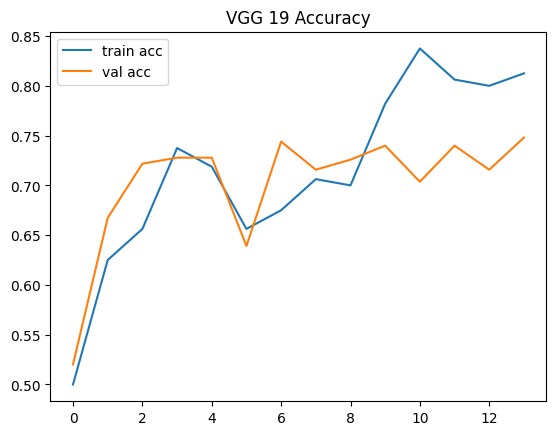

In [16]:
# accuracies
plt.plot(vgg_history.history['accuracy'], label='train acc')
plt.plot(vgg_history.history['val_accuracy'], label='val acc')
plt.title("VGG 19 Accuracy")
plt.legend()
plt.show()

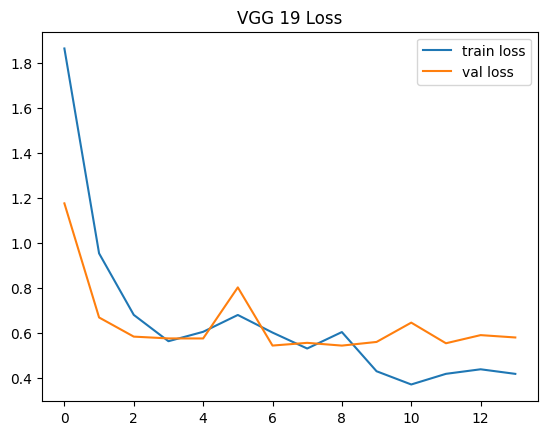

In [17]:
# loss
plt.plot(vgg_history.history['loss'], label='train loss')
plt.plot(vgg_history.history['val_loss'], label='val loss')
plt.title("VGG 19 Loss")
plt.legend()
plt.show()

In [18]:
#predict
y_pred = vgg_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,y_test))#get classification report

16/16 [==============================] - 2s 105ms/step
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       266
           1       0.64      0.68      0.66       234

    accuracy                           0.67       500
   macro avg       0.67      0.67      0.67       500
weighted avg       0.67      0.67      0.67       500



In [19]:
print(confusion_matrix(y_pred,y_test))#get confusion matrix

vgg_model.save("Model\AutismDetection_vgg_model.h5", save_format="h5")

[[176  90]
 [ 74 160]]


In [20]:
del vgg_history
del y_pred

gc.collect()

10162

# RESNET50 model

In [21]:
resnet_50 = ResNet50(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [22]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_50.layers:
    layer.trainable = False

In [23]:
x = Flatten()(resnet_50.output)

#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_model = Model(inputs=resnet_50.input, outputs=prediction)
resnet_50_model.summary()# view the structure of the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block1_0_conv (Conv2D)   (None, 56, 56, 256)  16640       ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    
                                                                                                  
 conv2_block1_0_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_3_conv[0][0]']    
 ization)                                                                                         
          

In [24]:
resnet_50_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

# fit the model
resnet_50_history = resnet_50_model.fit(x_train, y_train, validation_data=(x_val,y_val), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_val.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/60
10/10 [==============================] - 5s 260ms/step - loss: 3.7965 - accuracy: 0.5750 - val_loss: 4.2477 - val_accuracy: 0.5161
Epoch 2/60
10/10 [==============================] - 1s 151ms/step - loss: 3.0085 - accuracy: 0.4812 - val_loss: 2.0458 - val_accuracy: 0.5161
Epoch 3/60
10/10 [==============================] - 1s 149ms/step - loss: 1.4789 - accuracy: 0.5063 - val_loss: 1.6076 - val_accuracy: 0.4879
Epoch 4/60
10/10 [==============================] - 1s 159ms/step - loss: 1.0012 - accuracy: 0.5063 - val_loss: 0.7079 - val_accuracy: 0.5645
Epoch 5/60
10/10 [==============================] - 1s 161ms/step - loss: 0.7105 - accuracy: 0.5875 - val_loss: 0.7906 - val_accuracy: 0.5685
Epoch 6/60
10/10 [==============================] - 1s 149ms/step - loss: 0.8524 - accuracy: 0.5625 - val_loss: 0.7453 - val_accuracy: 0.5343
Epoch 7/60
10/10 [==============================] - 1s 159ms/step - loss: 0.7722 - accuracy: 0.6062 - val_loss: 0.6398 - val_accuracy: 0.6512
Epoch 

In [25]:
resnet_50_loss,resnet_50_acc = resnet_50_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50 Loss:", resnet_50_loss)
print("Resnet_50 Accuracy:", resnet_50_acc*100, "%")

16/16 [==============================] - 1s 63ms/step - loss: 0.6612 - accuracy: 0.6480
Resnet_50 Loss: 0.6611694097518921
Resnet_50 Accuracy: 64.80000019073486 %


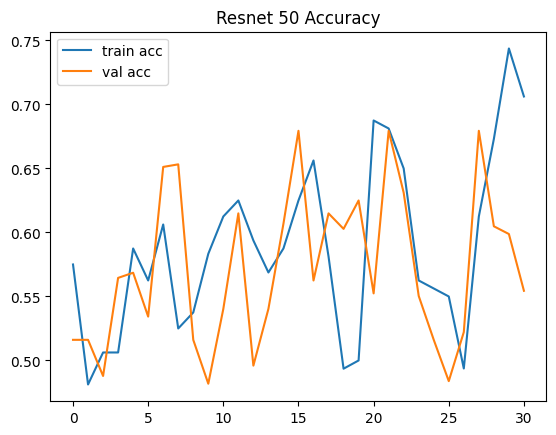

In [26]:
# accuracies
plt.plot(resnet_50_history.history['accuracy'], label='train acc')
plt.plot(resnet_50_history.history['val_accuracy'], label='val acc')
plt.title("Resnet 50 Accuracy")
plt.legend()
plt.show()

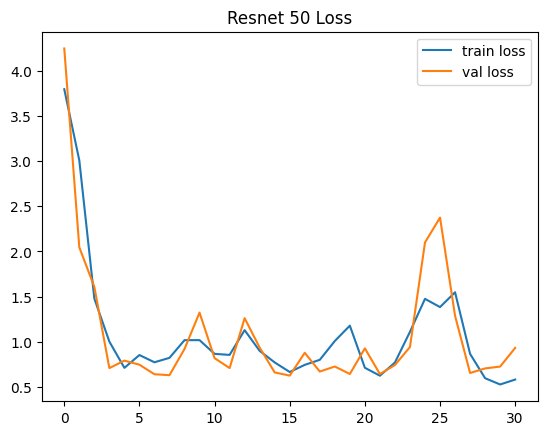

In [27]:
# loss
plt.plot(resnet_50_history.history['loss'], label='train loss')
plt.plot(resnet_50_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 Loss")
plt.legend()
plt.show()

In [28]:
#predict
y_pred=resnet_50_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

16/16 [==============================] - 2s 56ms/step
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       252
           1       0.64      0.65      0.65       248

    accuracy                           0.65       500
   macro avg       0.65      0.65      0.65       500
weighted avg       0.65      0.65      0.65       500



In [29]:
resnet_50_model.save("Model\AutismDetection_resnet_50_model.h5", save_format="h5")

del resnet_50_history
del y_pred

gc.collect()

10433

# RESNET50 V2

In [30]:
resnet_50_v2 = ResNet50V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [31]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_50_v2.layers:
    layer.trainable = False

In [32]:
x = Flatten()(resnet_50_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_v2_model = Model(inputs=resnet_50_v2.input, outputs=prediction)
# view the structure of the model
resnet_50_v2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_blo

In [33]:
resnet_50_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

# fit the model
resnet_50_v2_history = resnet_50_v2_model.fit(x_train, y_train, validation_data=(x_val,y_val), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_val.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/60
10/10 [==============================] - 5s 234ms/step - loss: 0.9741 - acc: 0.5312 - val_loss: 1.7733 - val_acc: 0.6089
Epoch 2/60
10/10 [==============================] - 1s 142ms/step - loss: 0.9655 - acc: 0.6000 - val_loss: 0.9472 - val_acc: 0.6573
Epoch 3/60
10/10 [==============================] - 1s 141ms/step - loss: 0.8049 - acc: 0.5938 - val_loss: 0.8770 - val_acc: 0.6552
Epoch 4/60
10/10 [==============================] - 1s 140ms/step - loss: 0.7224 - acc: 0.6687 - val_loss: 0.6578 - val_acc: 0.6976
Epoch 5/60
10/10 [==============================] - 1s 140ms/step - loss: 0.8294 - acc: 0.5813 - val_loss: 0.6215 - val_acc: 0.7016
Epoch 6/60
10/10 [==============================] - 1s 140ms/step - loss: 0.8460 - acc: 0.6062 - val_loss: 0.6123 - val_acc: 0.7056
Epoch 7/60
10/10 [==============================] - 1s 141ms/step - loss: 0.6486 - acc: 0.6562 - val_loss: 0.6055 - val_acc: 0.7097
Epoch 8/60
10/10 [==============================] - 1s 140ms/step - loss: 0.

In [34]:
resnet_50_v2_loss,resnet_50_v2_acc = resnet_50_v2_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50_V2 Loss:", resnet_50_v2_loss)
print("Resnet_50_V2 Accuracy:", resnet_50_v2_acc*100, "%")

16/16 [==============================] - 1s 59ms/step - loss: 0.8597 - acc: 0.7080
Resnet_50_V2 Loss: 0.8597337007522583
Resnet_50_V2 Accuracy: 70.80000042915344 %


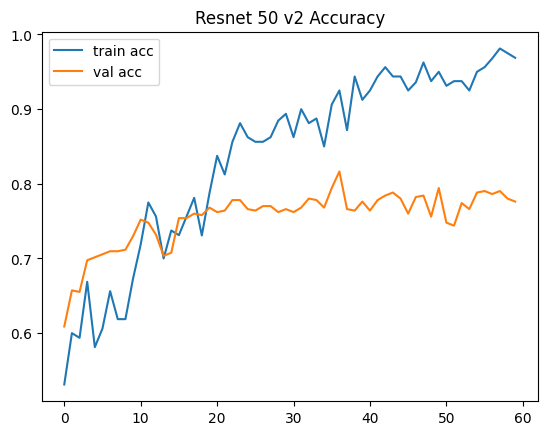

In [35]:
# accuracies
plt.plot(resnet_50_v2_history.history['acc'], label='train acc')
plt.plot(resnet_50_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 50 v2 Accuracy")
plt.legend()
plt.show()

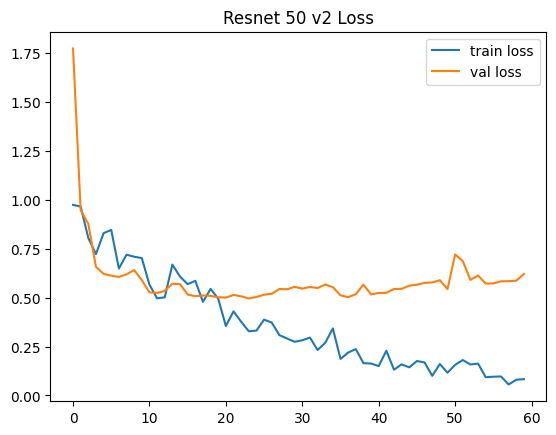

In [36]:
# loss
plt.plot(resnet_50_v2_history.history['loss'], label='train loss')
plt.plot(resnet_50_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 v2 Loss")
plt.legend()
plt.show()

In [37]:
#predict
y_pred=resnet_50_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

16/16 [==============================] - 2s 54ms/step
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       242
           1       0.72      0.70      0.71       258

    accuracy                           0.71       500
   macro avg       0.71      0.71      0.71       500
weighted avg       0.71      0.71      0.71       500



In [38]:
resnet_50_v2_model.save("Model\AutismDetection_resnet_50_v2_model.h5", save_format="h5")

#get confusion matrix
print(confusion_matrix(y_pred,y_test))

del resnet_50_v2_history
del y_pred

gc.collect()

[[173  69]
 [ 77 181]]


6549

# RESNET101V2

In [39]:
resnet_101_v2 = ResNet101V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [40]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_101_v2.layers:
    layer.trainable = False

In [41]:
x = Flatten()(resnet_101_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_101_v2_model = Model(inputs=resnet_101_v2.input, outputs=prediction)
# view the structure of the model
resnet_101_v2_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

 conv3_block3_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block3_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block3_2_pad[0][0]']     
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
          

In [42]:
resnet_101_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

# fit the model
resnet_101_v2_history = resnet_101_v2_model.fit(x_train, y_train, validation_data=(x_val,y_val), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_val.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/60
10/10 [==============================] - 8s 396ms/step - loss: 1.0327 - acc: 0.5250 - val_loss: 1.1279 - val_acc: 0.6230
Epoch 2/60
10/10 [==============================] - 2s 238ms/step - loss: 0.7687 - acc: 0.6250 - val_loss: 0.9854 - val_acc: 0.6290
Epoch 3/60
10/10 [==============================] - 2s 238ms/step - loss: 0.9047 - acc: 0.5875 - val_loss: 0.8414 - val_acc: 0.6694
Epoch 4/60
10/10 [==============================] - 2s 237ms/step - loss: 0.8344 - acc: 0.5875 - val_loss: 0.7299 - val_acc: 0.6512
Epoch 5/60
10/10 [==============================] - 2s 238ms/step - loss: 0.7845 - acc: 0.6125 - val_loss: 0.7344 - val_acc: 0.6492
Epoch 6/60
10/10 [==============================] - 2s 238ms/step - loss: 0.9773 - acc: 0.5437 - val_loss: 0.6381 - val_acc: 0.6653
Epoch 7/60
10/10 [==============================] - 2s 238ms/step - loss: 0.7971 - acc: 0.6250 - val_loss: 0.6080 - val_acc: 0.6694
Epoch 8/60
10/10 [==============================] - 2s 238ms/step - loss: 0.

In [43]:
resnet_101_v2_loss,resnet_101_v2_acc = resnet_101_v2_model.evaluate(x_test,y_test,batch_size=32)
print("resnet_101_v2 Loss:", resnet_101_v2_loss)
print("resnet_101_v2 Accuracy:", resnet_101_v2_acc*100, "%")

16/16 [==============================] - 2s 103ms/step - loss: 0.8068 - acc: 0.7220
resnet_101_v2 Loss: 0.8067845702171326
resnet_101_v2 Accuracy: 72.2000002861023 %


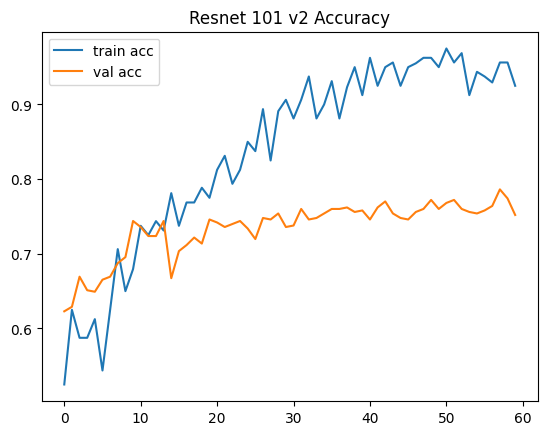

In [44]:
# accuracies
plt.plot(resnet_101_v2_history.history['acc'], label='train acc')
plt.plot(resnet_101_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 101 v2 Accuracy")
plt.legend()
plt.show()

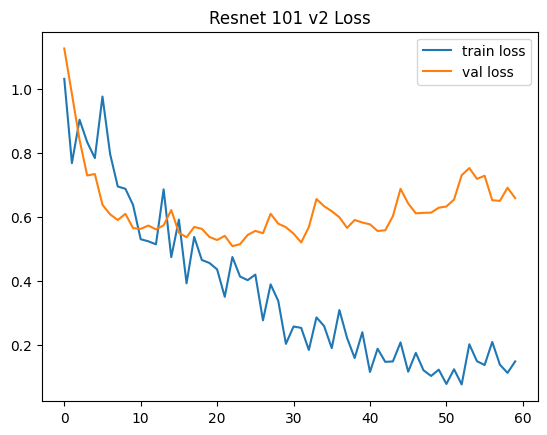

In [45]:
# loss
plt.plot(resnet_101_v2_history.history['loss'], label='train loss')
plt.plot(resnet_101_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 101 v2 Loss")
plt.legend()
plt.show()

In [46]:
#predict
y_pred=resnet_101_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

16/16 [==============================] - 3s 111ms/step
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       247
           1       0.73      0.72      0.72       253

    accuracy                           0.72       500
   macro avg       0.72      0.72      0.72       500
weighted avg       0.72      0.72      0.72       500



In [47]:
resnet_101_v2_model.save("Model\AutismDetection_resnet_101_v2_model.h5", save_format="h5")

#get confusion matrix
print(confusion_matrix(y_pred,y_test))

del resnet_101_v2_history
del y_pred

gc.collect()

[[179  68]
 [ 71 182]]


7915

# Model comparision

[67.1999990940094, 64.80000019073486, 70.80000042915344, 72.2000002861023]


Text(0.5, 1.0, 'Accuracy score Comparison (Higher is better)')

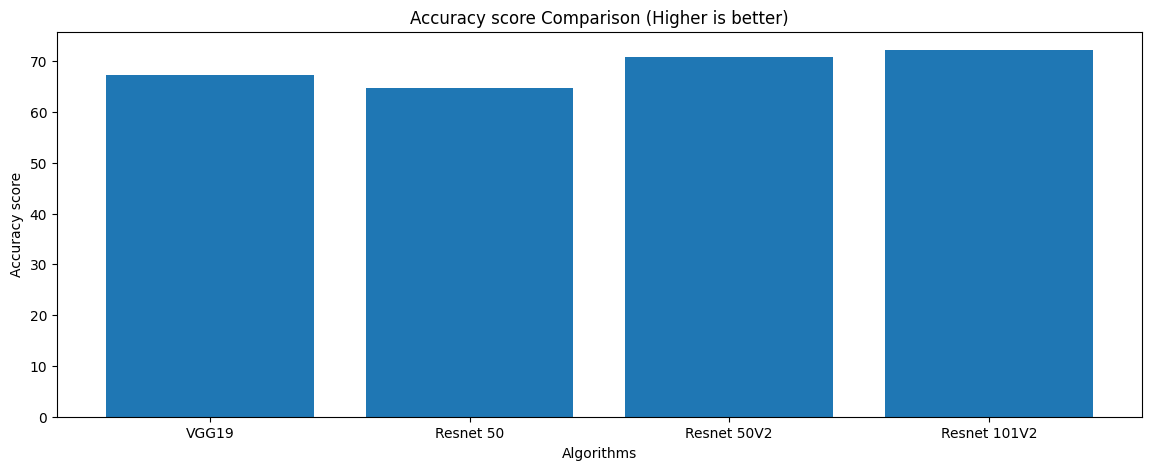

In [48]:
algorithms = ["VGG19","Resnet 50","Resnet 50V2","Resnet 101V2"]
Accuracy = [vgg_acc*100,resnet_50_acc*100,resnet_50_v2_acc*100,resnet_101_v2_acc*100]
print(Accuracy)

plt.figure(figsize=[14,5])
plt.bar(algorithms, Accuracy)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")
plt.title("Accuracy score Comparison (Higher is better)")

## Inference

In [49]:
from tensorflow.keras.models import load_model

IMAGE_SIZE = (224, 224, 3)
CATEGORIES = ['Autistic', 'Normal']

model = load_model("Model\AutismDetection_resnet_101_v2_model.h5")



def detect_Autism(imgpath):
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    img_rotated_180 = cv2.rotate(img, cv2.ROTATE_180)
    img_rotated_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_flip_ver = cv2.flip(img, 0)
    img_flip_hor = cv2.flip(img, 1)

    images = []
    images.append(img)
    images.append(img_rotated_90)
    images.append(img_rotated_180)
    images.append(img_rotated_270)
    images.append(img_flip_ver)
    images.append(img_flip_hor)

    images = np.array(images)
    images = images.astype(np.float32)
    images /= 255

    op = []
    # make predictions on the input image
    for im in images:
        image = np.array(im)
        image = np.expand_dims(image, axis=0)
        pred = model.predict(image)
        pred = pred.argmax(axis=1)[0]
        op.append(pred)
        # print("Pred:", pred, CATEGORIES[pred])

    op = np.array(op)
    print("Final Output:", CATEGORIES[np.bincount(op).argmax()])
    return CATEGORIES[np.bincount(op).argmax()]



print(detect_Autism(r"Autism dataset\test data\0025.jpg"))

1/1 [==============================] - 0s 28ms/step
Final Output: Autistic
Autistic

1/1 [==============================] - 0s 27ms/step
Final Output: Normal
Normal
